<a href="https://colab.research.google.com/github/vinicius-mattoso/LearningHub/blob/main/time_series/01_eda_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA) of Time Series — AirPassengers

This notebook is part of the **Learning Hub** and focuses on the exploratory analysis of a classic time series dataset: **AirPassengers** (monthly airline passengers).

## Goals
By the end of this notebook, you should be able to:
- Identify **trend**, **seasonality** and **variance changes**
- Understand what **stationarity** means and why it matters
- Apply common **transformations** (log, differencing, seasonal differencing)
- Use **ACF/PACF** and **Ljung-Box** to diagnose autocorrelation
- Decide what kind of preprocessing is usually needed before forecasting models

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

## 1. Dataset

We will use **AirPassengers**, a monthly dataset widely used in time series examples.

### Why this dataset?
- It contains a clear **upward trend**
- It has strong **seasonality**
- It shows **increasing variance** over time (a common real-world behavior)

In [2]:
DATA_URL = "https://raw.githubusercontent.com/selva86/datasets/master/AirPassengers.csv"

df = pd.read_csv(DATA_URL)
df.columns = [c.strip().lower() for c in df.columns]

if not {"date", "value"}.issubset(df.columns):
    raise ValueError(f"Expected columns date,value; got: {df.columns.tolist()}")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

y = df["value"].astype(float)

# Normalize to month-end and set frequency
y.index = y.index.to_period("M").to_timestamp("M")
y = y.asfreq("ME")

y.head(), y.tail()


(date
 1949-01-31    112.0
 1949-02-28    118.0
 1949-03-31    132.0
 1949-04-30    129.0
 1949-05-31    121.0
 Freq: ME, Name: value, dtype: float64,
 date
 1960-08-31    606.0
 1960-09-30    508.0
 1960-10-31    461.0
 1960-11-30    390.0
 1960-12-31    432.0
 Freq: ME, Name: value, dtype: float64)

## 2. Quick overview

Before plotting anything, we should answer:
- What is the time range?
- Is the frequency consistent?
- Are there missing values?
- What is the scale/distribution?


In [3]:
info = {
    "rows": len(y),
    "start": y.index.min(),
    "end": y.index.max(),
    "freq": y.index.freqstr,
    "missing": int(y.isna().sum())
}

info


{'rows': 144,
 'start': Timestamp('1949-01-31 00:00:00'),
 'end': Timestamp('1960-12-31 00:00:00'),
 'freq': 'ME',
 'missing': 0}

In [4]:
y.describe()

,value
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## 3. Plot the raw series

A raw time series plot often reveals:
- Trend (long-term direction)
- Seasonality (repeating patterns)
- Variance changes (heteroscedasticity)
- Outliers or structural breaks

Let's start with the raw plot.


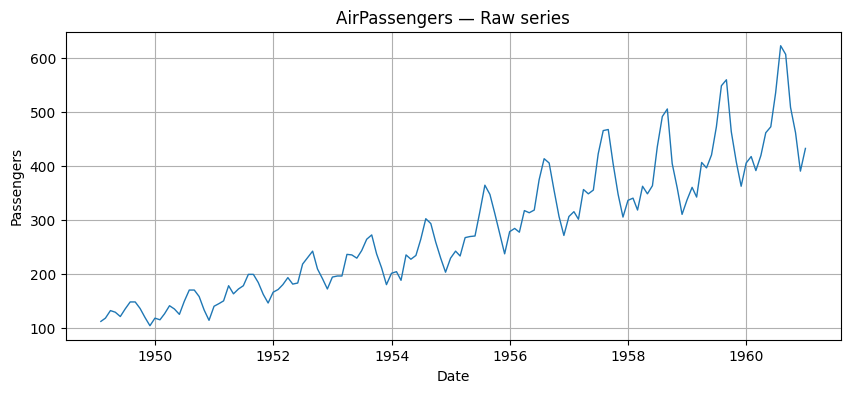

In [5]:
plt.figure()
plt.plot(y.index, y.values, linewidth=1)
plt.title("AirPassengers — Raw series")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.show()


## 4. Rolling statistics (mean and std)

A common first check for stationarity:
- If the **mean** changes over time → likely non-stationary
- If the **variance/std** changes over time → often needs transformation (e.g., log)

We'll use a 12-month rolling window to match the yearly seasonality.


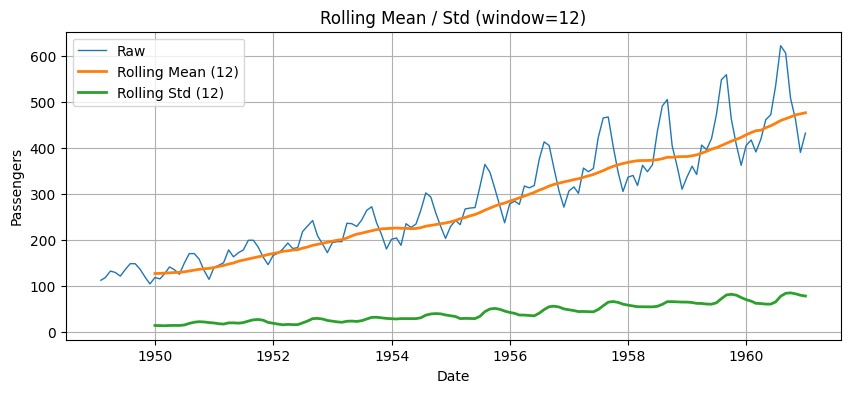

In [6]:
roll_window = 12
rolling_mean = y.rolling(roll_window).mean()
rolling_std = y.rolling(roll_window).std()

plt.figure()
plt.plot(y.index, y.values, label="Raw", linewidth=1)
plt.plot(rolling_mean.index, rolling_mean.values, label=f"Rolling Mean ({roll_window})", linewidth=2)
plt.plot(rolling_std.index, rolling_std.values, label=f"Rolling Std ({roll_window})", linewidth=2)
plt.title("Rolling Mean / Std (window=12)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.show()


## 5. Decomposition: additive vs multiplicative

Decomposition separates the series into:
- Trend
- Seasonality
- Residual (noise)

### Additive model
Assumes: `y = trend + seasonality + residual`

### Multiplicative model
Assumes: `y = trend * seasonality * residual`

A common rule of thumb:
- If seasonal fluctuations look roughly constant → additive may fit
- If seasonal fluctuations grow with the level → multiplicative is often better


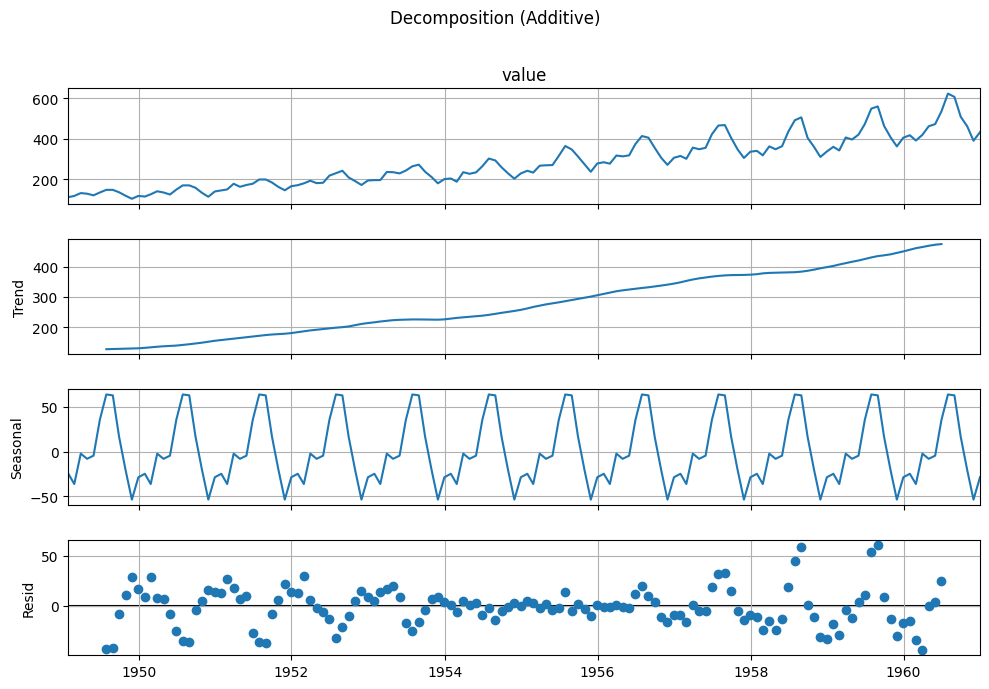

In [7]:
decomp_add = seasonal_decompose(y, model="additive", period=12)
fig = decomp_add.plot()
fig.set_size_inches(10, 7)
plt.suptitle("Decomposition (Additive)", y=1.02)
plt.show()


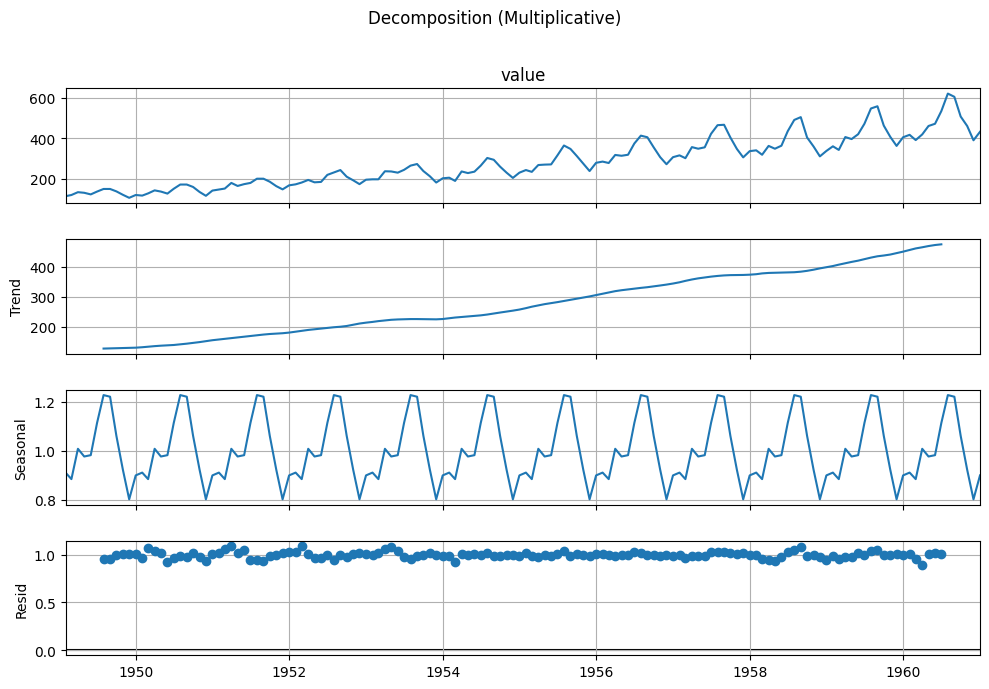

In [8]:
decomp_mul = seasonal_decompose(y, model="multiplicative", period=12)
fig = decomp_mul.plot()
fig.set_size_inches(10, 7)
plt.suptitle("Decomposition (Multiplicative)", y=1.02)
plt.show()


## Interpretation: Additive vs Multiplicative Decomposition

By comparing the additive and multiplicative decompositions, we can better understand how the
components of the time series interact over time.

### Additive decomposition

In the additive model, the series is assumed to be composed as:

y = trend + seasonality + residual

From the additive decomposition, we observe:
- A clear upward **trend**
- A **seasonal component with constant amplitude**
- Residuals whose variance increases over time

This last point is important: the magnitude of the seasonal fluctuations in the original series
clearly grows as the level of the series increases, but the additive model forces the seasonal
component to remain constant. As a result, part of the structure is pushed into the residuals,
leading to heteroscedastic behavior.

---

### Multiplicative decomposition

In the multiplicative model, the series is assumed to be composed as:

y = trend × seasonality × residual

From the multiplicative decomposition, we observe:
- A trend similar to the additive case
- A **seasonal component expressed as relative effects** (ratios around 1)
- Residuals that are more stable and centered, with variance approximately constant over time

In this formulation, seasonal fluctuations naturally scale with the level of the series, which
matches the visual behavior of the data.

---

### Why the multiplicative model fits better

The AirPassengers series exhibits:
- Increasing variance over time
- Seasonal effects whose amplitude grows with the level of the series

These characteristics are better captured by a multiplicative structure. As a result:
- The seasonal component is more consistent
- The residuals behave closer to white noise
- The overall decomposition is more interpretable

This also explains why transformations such as the **log transform** are commonly applied to this
dataset: taking the logarithm converts a multiplicative structure into an additive one, which
simplifies modeling and stationarity assumptions.


## 6. Transformations

Time series often require transformations before modeling.

### Why log transform?
If variance increases with the level of the series, the log transform can stabilize variance.

### Why differencing?
Differencing helps remove trend and make the series closer to stationary.

### Why seasonal differencing?
For monthly data with yearly seasonality, `diff(12)` often removes the seasonal component.


In [9]:
y_log = np.log(y)

y_diff1 = y.diff()
y_seasonal_diff = y.diff(12)

y_log_diff1 = y_log.diff()
y_log_seasonal_diff = y_log.diff(12)

# common SARIMA prep: log + diff1 + seasonal diff
y_log_diff1_seas = y_log.diff().diff(12)

series_dict = {
    "raw": y,
    "log": y_log,
    "diff1": y_diff1,
    "seasdiff12": y_seasonal_diff,
    "logdiff1": y_log_diff1,
    "logseasdiff12": y_log_seasonal_diff,
    "logdiff1_seasdiff12": y_log_diff1_seas,
}


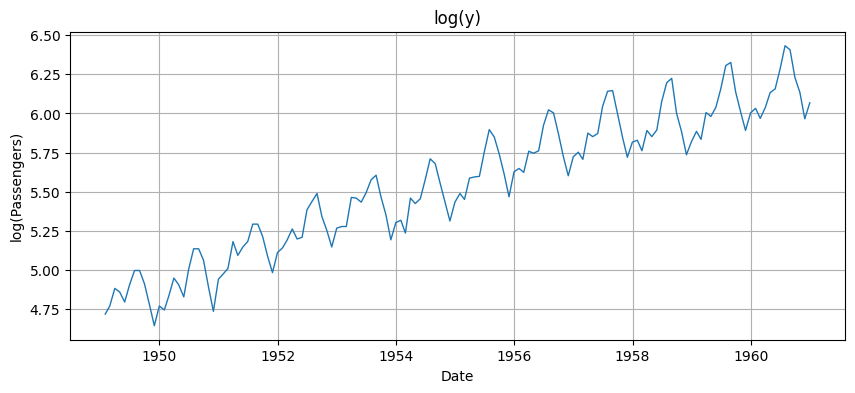

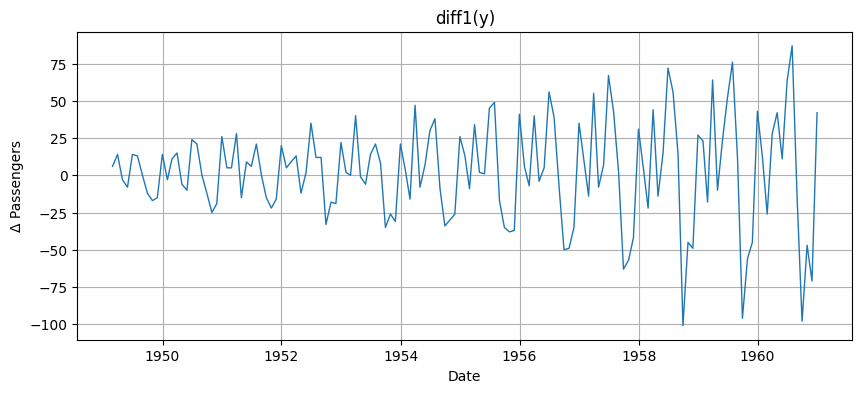

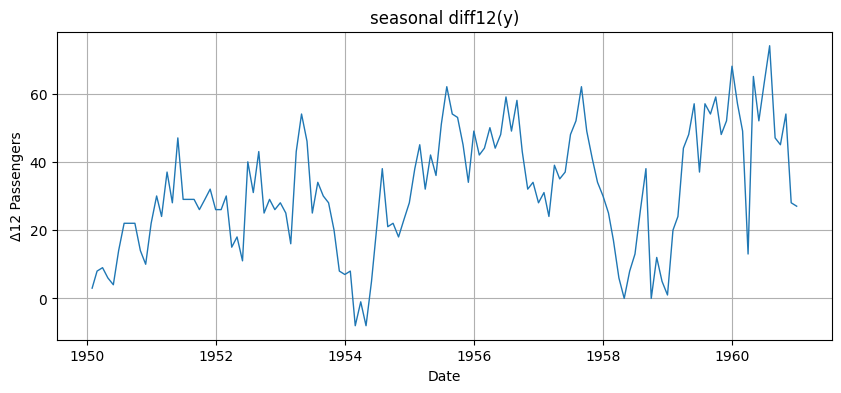

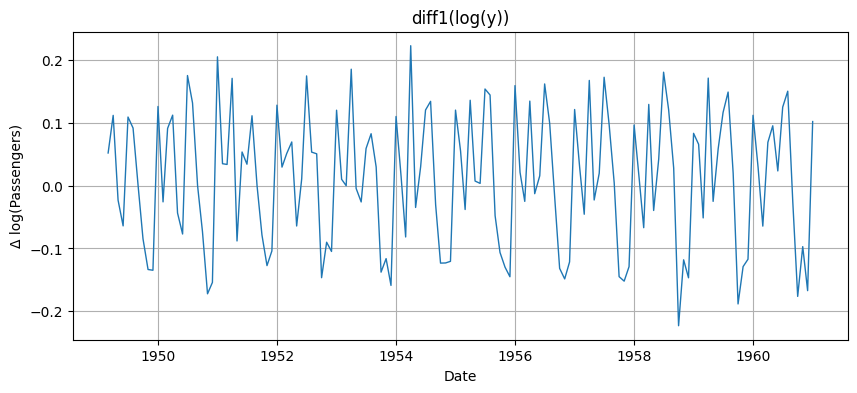

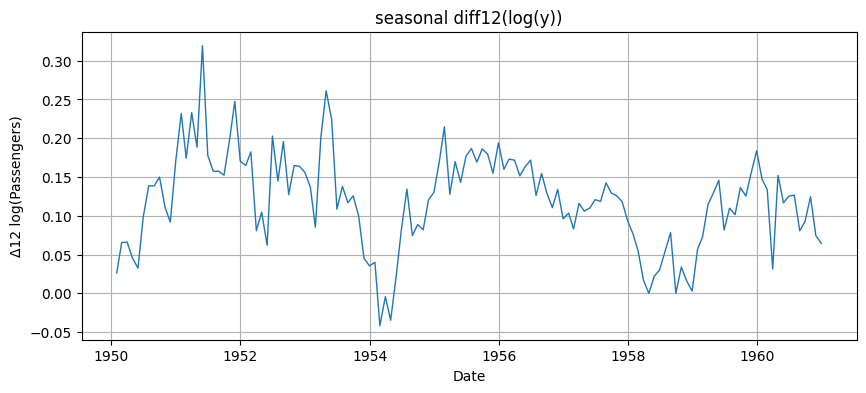

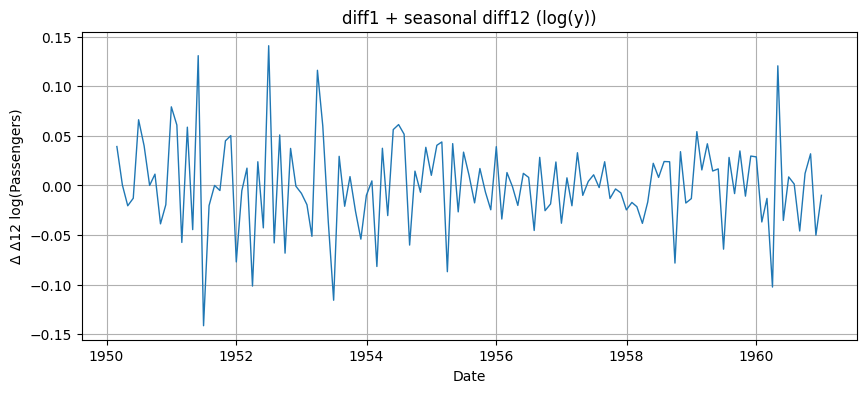

In [10]:
def plot_series(s: pd.Series, title: str, ylabel: str):
    s = s.dropna()
    plt.figure()
    plt.plot(s.index, s.values, linewidth=1)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.show()

plot_series(y_log, "log(y)", "log(Passengers)")
plot_series(y_diff1, "diff1(y)", "Δ Passengers")
plot_series(y_seasonal_diff, "seasonal diff12(y)", "Δ12 Passengers")
plot_series(y_log_diff1, "diff1(log(y))", "Δ log(Passengers)")
plot_series(y_log_seasonal_diff, "seasonal diff12(log(y))", "Δ12 log(Passengers)")
plot_series(y_log_diff1_seas, "diff1 + seasonal diff12 (log(y))", "Δ Δ12 log(Passengers)")


## 7. Autocorrelation diagnostics: ACF and PACF

- **ACF** shows correlation between the series and its lags.
- **PACF** shows the correlation with a lag after removing the effect of shorter lags.

In practice:
- ACF/PACF help you understand how “memory” exists in the series
- They also support choices of AR/MA orders (e.g., in ARIMA/SARIMA)


In [13]:
def plot_acf_pacf_compact(s: pd.Series, name: str, lags: int = 36):
    s = s.dropna()
    lags = min(lags, max(1, (len(s) // 2) - 1))

    plt.figure(figsize=(10, 4))
    plot_acf(s, ax=plt.gca(), lags=lags)
    plt.title(f"ACF — {name} (lags={lags})")
    plt.show()

    plt.figure(figsize=(10, 4))
    plot_pacf(s, ax=plt.gca(), lags=lags, method="ywm")
    plt.title(f"PACF — {name} (lags={lags})")
    plt.show()


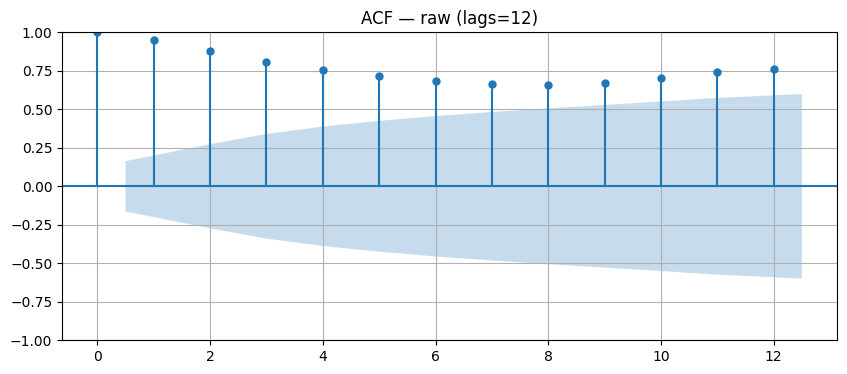

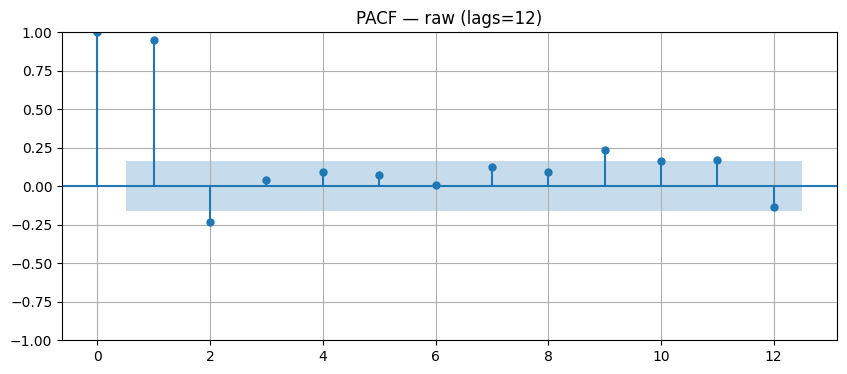

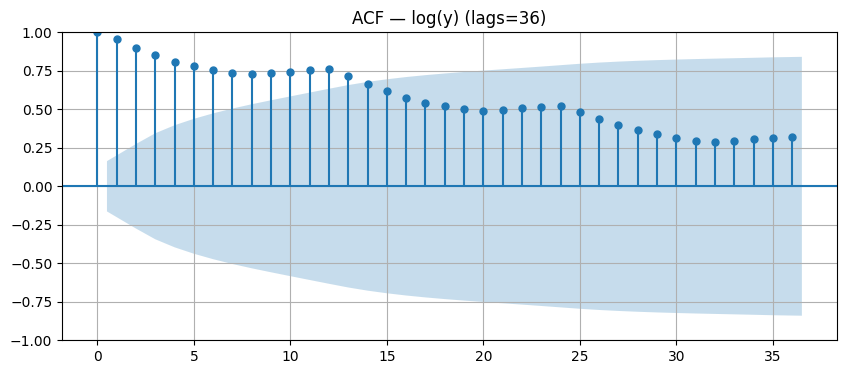

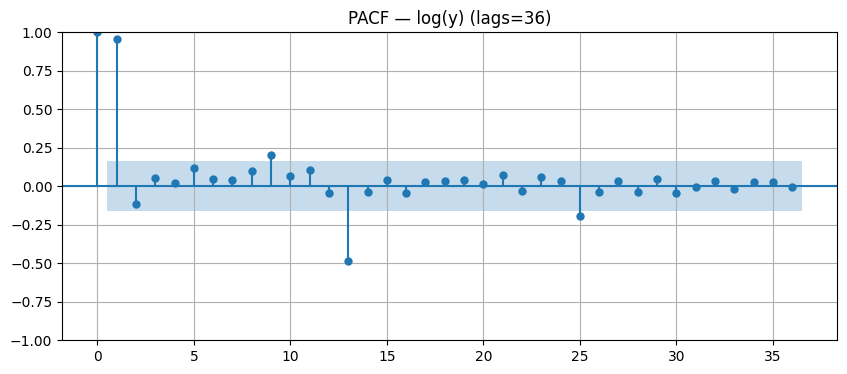

In [20]:
plot_acf_pacf_compact(y, "raw",lags=12)
plot_acf_pacf_compact(y_log, "log(y)")


## 8. Stationarity & residual autocorrelation tests

### ADF (Augmented Dickey-Fuller)
- **H0:** unit root → series is **non-stationary**
- If p-value < 0.05 → reject H0 → evidence of stationarity

### KPSS
- **H0:** series is **stationary**
- If p-value < 0.05 → reject H0 → evidence of non-stationarity

### Ljung-Box
- **H0:** no autocorrelation up to given lags
- If p-value < 0.05 → autocorrelation is present

We’ll run the tests for the raw series and key transformations.


In [18]:
def diagnostics_summary(series_map: dict, lb_lags=(12, 24)) -> pd.DataFrame:
    rows = []
    for name, s in series_map.items():
        s = s.dropna()

        # ADF (H0: non-stationary)
        adf_stat, adf_p, *_ = adfuller(s, autolag="AIC")

        # KPSS (H0: stationary)
        kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")

        # Ljung-Box (H0: no autocorrelation up to lag)
        lb = acorr_ljungbox(s, lags=list(lb_lags), return_df=True)
        lb_p12 = float(lb.loc[lb.index[0], "lb_pvalue"])
        lb_p24 = float(lb.loc[lb.index[1], "lb_pvalue"]) if len(lb_lags) > 1 else np.nan

        rows.append({
            "series": name,
            "n": len(s),
            "ADF p-value": adf_p,
            "KPSS p-value": kpss_p,
            "LB p@12": lb_p12,
            "LB p@24": lb_p24,
            "stationary? (rule-of-thumb)": ("yes" if (adf_p < 0.05 and kpss_p > 0.05) else "no"),
        })

    return pd.DataFrame(rows).set_index("series")


In [19]:
series_for_tests = {
    "raw": y,
    "log(y)": y_log,
    "log(y) diff1 + seasdiff12": y_log_diff1_seas,
}

summary = diagnostics_summary(series_for_tests, lb_lags=(12, 24))
summary.style.format({
    "ADF p-value": "{:.4f}",
    "KPSS p-value": "{:.4f}",
    "LB p@12": "{:.4f}",
    "LB p@24": "{:.4f}",
})


/tmp/ipython-input-361555353.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
/tmp/ipython-input-361555353.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")
/tmp/ipython-input-361555353.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")


,n,ADF p-value,KPSS p-value,LB p@12,LB p@24,stationary? (rule-of-thumb)
series,,,,,,
raw,144,0.9919,0.0100,0.0000,0.0000,no
log(y),144,0.4224,0.0100,0.0000,0.0000,no
log(y) diff1 + seasdiff12,131,0.0002,0.1000,0.0000,0.0000,yes


## Interpretation of the diagnostics summary

The table above summarizes the main statistical diagnostics for selected versions of the series.

### Raw series
- **ADF p-value ≈ 0.99** → strong evidence of a unit root (non-stationary)
- **KPSS p-value ≈ 0.01** → rejects stationarity
- **Ljung-Box p-values ≈ 0.00** → strong autocorrelation remains

This confirms what we saw visually: the raw series is clearly **non-stationary**, with trend, seasonality
and strong temporal dependence.

---

### Log-transformed series
- The log transform helps stabilize variance
- However, **ADF still fails** to reject non-stationarity
- **KPSS still rejects stationarity**
- Strong autocorrelation remains

Conclusion: the log transform alone is **not sufficient** to achieve stationarity.

---

### Log + first difference + seasonal difference
- **ADF p-value < 0.05** → rejects unit root
- **KPSS p-value > 0.05** → fails to reject stationarity
- This combination satisfies the common rule-of-thumb for stationarity

Even though autocorrelation is still detected by Ljung-Box (expected in many real-world series), this
transformed series is **much closer to stationarity** and is typically a good starting point for
classical time series models such as SARIMA.


### Note on KPSS interpolation warnings

You may notice warnings such as:

> *The test statistic is outside of the range of p-values available in the look-up table.*

This warning is **not an error**.

It simply means that the KPSS test statistic is either:
- much larger than the values tabulated (very strong evidence against stationarity), or
- much smaller than the values tabulated (very strong evidence in favor of stationarity)

In these cases, the reported p-value is a **boundary approximation**, and the correct interpretation
should be qualitative rather than exact.

In practice:
- **KPSS p ≈ 0.01** → strong evidence of non-stationarity
- **KPSS p ≈ 0.10** → no evidence against stationarity

For EDA purposes, this behavior is expected and does not invalidate the conclusions.
